In [1]:
using LinearAlgebra

## Chapter 7
# Matrix examples
### 7.1 Geometric transformations

Let’s create a rotation matrix, and use it to rotate a set of points $π/3$ radians ($60^{\circ}$). The result is in Figure 7.1.

In [2]:
Rot(theta) = [cos(theta) -sin(theta); sin(theta) cos(theta)];
R = Rot(pi/3)

2×2 Matrix{Float64}:
 0.5       -0.866025
 0.866025   0.5

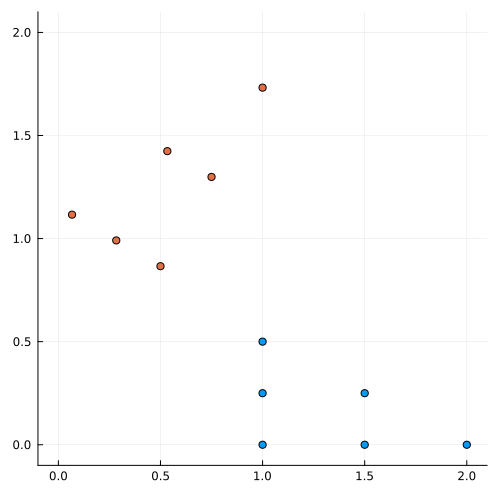

In [3]:
# Create a list of 2-D points
points = [ [1,0], [1.5,0], [2,0], [1,0.25], [1.5, 0.25], [1,.5] ];
# Now rotate them.
rpoints = [ R*p for p in points ];
# Show the two sets of points.
using Plots
scatter([c[1] for c in points], [c[2] for c in points])
scatter!([c[1] for c in rpoints], [c[2] for c in rpoints])
plot!(lims = (-0.1, 2.1), size = (500,500), legend = false)

**Figure 7.1** Counterclockwise rotation by 60 degrees applied to six points.

### 7.2 Selectors
**Reverser matrix.** The reverser matrix can be created from an identity matrix by reversing the order of its rows. The Julia command reverse can be used for this purpose. `(reverse(A,dims=1)` reverses the order of the rows of a matrix; `flipdim(A,dims=2)` reverses the order of the columns.) Multiplying a vector with a reverser matrix is the same as reversing the order of its entries directly.

In [4]:
reverser(n) = reverse(Matrix(I(5)), dims = 1)

reverser (generic function with 1 method)

In [5]:
A = reverser(5)

5×5 Matrix{Bool}:
 0  0  0  0  1
 0  0  0  1  0
 0  0  1  0  0
 0  1  0  0  0
 1  0  0  0  0

In [6]:
x = [1., 2., 3., 4., 5.];
A*x # Reverse x by multiplying with reverser matrix.

5-element Vector{Float64}:
 5.0
 4.0
 3.0
 2.0
 1.0

In [7]:
reverse(x) # Reverse x directly.

5-element Vector{Float64}:
 5.0
 4.0
 3.0
 2.0
 1.0

**Permutation matrix.** Let’s create a permutation matrix and use it to permute the entries of a vector. In Julia, there is no reason to create a matrix to carry out the permutation, since we can do the same thing directly by passing in the permuted indexes to the vector.

In [8]:
A = [0 0 1; 1 0 0; 0 1 0]
x = [0.2, -1.7, 2.4]
A*x # Permutes entries of x to [x[3],x[1],x[2]]
x[[3,1,2]] # Same thing using permuted indices

3-element Vector{Float64}:
  2.4
  0.2
 -1.7

### 7.3 Incidence matrix
**Incidence matrix of a graph.** We create the incidence matrix of the network shown in Figure [7.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.7.3) in VMLS. 

In [9]:
 A = [ -1 -1 0 1 0; 1 0 -1 0 0 ; 0 0 1 -1 -1 ; 0 1 0 0 1]

4×5 Matrix{Int64}:
 -1  -1   0   1   0
  1   0  -1   0   0
  0   0   1  -1  -1
  0   1   0   0   1

In [10]:
xcirc = [1, -1, 1, 0, 1] # A circulation

5-element Vector{Int64}:
  1
 -1
  1
  0
  1

In [11]:
A*xcirc

4-element Vector{Int64}:
 0
 0
 0
 0

In [12]:
s = [1,0,-1,0]; # A source vector
x = [0.6, 0.3, 0.6, -0.1, -0.3]; # A flow vector
A*x + s # Total incoming flow at each node

4-element Vector{Float64}:
 1.1102230246251565e-16
 0.0
 0.0
 0.0

**Dirichlet energy.** On page [135](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.172) of VMLS we compute the Dirichlet energy of two potential vectors associated with the graph of Figure [7.2](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.7.2) in VMLS.

In [13]:
A = [ -1 -1 0 1 0 ; 1 0 -1 0 0 ; 0 0 1 -1 -1; 0 1 0 0 1 ]

4×5 Matrix{Int64}:
 -1  -1   0   1   0
  1   0  -1   0   0
  0   0   1  -1  -1
  0   1   0   0   1

In [14]:
vsmooth = [ 1, 2, 2, 1 ]

4-element Vector{Int64}:
 1
 2
 2
 1

In [15]:
vrough = [ 1, -1, 2, -1 ]

4-element Vector{Int64}:
  1
 -1
  2
 -1

In [16]:
norm(A'*vsmooth)^2, norm(A'*vrough)^2 # Dirichlet energy of vsmooth and vrough

(2.9999999999999996, 27.0)

### 7.4 Convolution
The Julia package `DSP` (Digital Signal Processing) includes a convolution function `conv`. After adding this package, the command `conv(a,b)` can be used to compute the convolution of the vectors `a` and `b`. Let’s use this to find the coefficients of the polynomial 
$$
p(x) = (1 + x)(2 − x+ x^2)(1 + x− 2x^2) = 2 + 3x− 3x^2 − x^3 + x^4 − 2x^5.
$$

In [17]:
# import Pkg; Pkg.add("DSP")

In [18]:
using DSP
a = [1,1]; # coefficients of 1+x
b = [2,-1,1]; # coefficients of 2-x+x^2
c = [1,1,-2]; # coefficients of 1+x-2x^2
d = conv(conv(a,b),c) # coefficients of product

6-element Vector{Int64}:
  2
  3
 -3
 -1
  1
 -2

Let’s write a function that creates a $Toeplitz$ matrix, and check it against the
`conv` function. We will also check that Julia is using the very efficient method for
computing the convolution.

To construct the $Toeplitz$ matrix $T(b)$ defined in equation ([7.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.7.4.3)) of VMLS, we
first create a zero matrix of the correct dimensions $((n + m − 1) × n)$ and then
add the coefficients bi one by one. Single-index indexing comes in handy for this
purpose. The single-index indexes of the elements $b_i$ in the matrix $T (b)$ are $i,
i+m+ n, i+ 2(m+ n), . . . , i+ (n− 1)(m+ n)$. 

In [19]:
function toeplitz(b,n)
    m = length(b)
    T = zeros(n+m-1,n)
    for i=1:m
        T[i : n+m : end] .= b[i]
    end
    return T
end
b = [-1,2,3]; a = [-2,3,-1,1];
Tb = toeplitz(b, length(a))

6×4 Matrix{Float64}:
 -1.0   0.0   0.0   0.0
  2.0  -1.0   0.0   0.0
  3.0   2.0  -1.0   0.0
  0.0   3.0   2.0  -1.0
  0.0   0.0   3.0   2.0
  0.0   0.0   0.0   3.0

In [20]:
Tb*a, conv(b,a)

([2.0, -7.0, 1.0, 6.0, -1.0, 3.0], [2, -7, 1, 6, -1, 3])

In [21]:
m = 2000; n = 2000;
b = randn(n); a=randn(m);
@time ctoep = toeplitz(b,n)*a;
@time cconv = conv(a,b);
norm(ctoep - cconv)

  0.032792 seconds (20.70 k allocations: 62.338 MiB, 14.52% gc time, 43.21% compilation time)
  0.006600 seconds (91 allocations: 160.578 KiB, 37.68% compilation time)


2.631172520988348e-12